# Topic 5 Assignment By Wilson Peguero Rosario

## Problem Statement

In this assignment, practical training issues are considered. There will be three basic issues addressed: the first describes things that need to be done prior to training a network, such as collecting and pre-processing data and selecting the network architecture; the second addresses network training itself; and the final considers post-training analysis. A case study is constructed for pattern recognition.

Assume a produce dealer has a warehouse that stores a variety of fruits and vegetables. When fruit is brought to the warehouse, various types of fruit may be mixed. The dealer wants a machine that will sort the fruit according to type. There is a conveyor belt on which the fruit is loaded. This conveyor belt passes through a set of sensors, which measure three properties of the fruit: shape, texture, and weight. These sensors are somewhat primitive. The shape sensor will output a 1 if the fruit is approximately round and a -1 if it is more elliptical. The texture sensor will output a 1 if the surface of the fruit is smooth and a -1 if it is rough. The weight sensor will output a 1 if the fruit is more than one pound and a -1 if it is less than one pound. The three sensor outputs will then be input to a neural network. The purpose of the network is to decide which kind of fruit is on the conveyor, so that the fruit can be directed to the correct storage bin. To make the problem even simpler, assume that there are only two kinds of fruit on the conveyor belt: banana and pineapple.

## Key Notes

- Client Requires algorithm for sorting fruit according to type
    - Categorical data based on whether the fruit is a citrus, etc.
- Conveyor belt passes the fruit through a sensor which extracts three properties from the fruit
    1. Shape
        - output is binary (1 if the fruit is round, -1 if the fruit is elliptical)
    2. Texture
        - output is binary (1 if the fruit is smooth, -1 if the fruit is rough)
    3. Weight
        - output is binary (1 if the fruit is more than 1 lb, -1 if the fruit is less than 1 lb)
- Assume that there are only two kinds of fruit on the conveyor belt
    1. Banana (shape:-1, texture:1, weight:-1)
    2. Pineapple (shape:-1, texture:-1, weight:1)

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Data Collection/Preparation

Now that the relevant libraries have been updated, one should be able to replicate the data necessary to develop the Neural Network. The average Pineapple weighs approximately 2 lbs, whereas a banana weighs less than half a pound. This makes it safe to assume that the weight feature will be consistent throughout the entirety of the data set (there will not be many pineapples whose weight is less than 1 lb and there will not be many bananas that weigh more than 1 lb). Texture is also an inherent feature of pineapples and bananas, meaning that a banana will always be smooth whereas a pineapple will always be rough. The feature with the most variation may be in the terms of shape for pineapples.

To develop the data, numpy and pandas libraries were used to create random selection between the number 1 or -1 for each feature (shape, texture, and weight) and develop the data set.

In [2]:
list__dataset = []
for _ in range(30000):
    shape = np.random.choice([-1,1], replace=False)
    texture = np.random.choice([-1,1], replace=False)
    weight = np.random.choice([-1,1], replace=False)
    if texture == 1 and shape == -1:
        label = "banana"
    elif texture == -1 or (texture == -1 and weight == 1):
        label = "pineapple"
    else:
        label = "banana"
    list__dataset.append({"label":label, "shape":shape, "texture":texture, "weight":weight})

df__dataset = pd.DataFrame(list__dataset)

## Data Exploration

Now that the data has been collected and formatted into the version apt for developing algorithms, it can be explored and some analytics can be taken from the data set.

In [3]:
df__dataset.describe()

,shape,texture,weight
count,30000.000000,30000.000000,30000.000000
mean,-0.007733,0.000800,-0.002267
std,0.999987,1.000016,1.000014
min,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000
50%,-1.000000,1.000000,-1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


From the above, one is able to tell immediately that majority of the samples within the data set belong to the pineapples as the mean texture value is negative. There are indications that out of the fruits, most weigh more than 1 lb and their shape is mostly round. One can confirm this by running a summary of the labels (shown below).

In [4]:
df__dataset['label'].value_counts()

banana       15012
pineapple    14988
Name: label, dtype: int64

Now one can create a copy of the original data set and exchange the values based on the table below:

| Feature | Value | Definition |
|---------|-------|------------|
| Shape   | -1    | Elliptical |
| Shape   |  1    | Round      |
| Texture | -1    | Rough      |
| Texture |  1    | Smooth     |
| Weight  | -1    | <1 lb      |
| Weight  |  1    | >1 lb      |

In [5]:

df__data_copy = df__dataset.copy()
df__data_copy['shape'].replace({1:"Round",-1:"Elliptical"}, inplace=True)
df__data_copy['texture'].replace({1:"Smooth",-1:"Rough"}, inplace=True)
df__data_copy['weight'].replace({1:">1 lb",-1:"<1 lb"}, inplace=True)
df__data_copy.head(10)

,label,shape,texture,weight
0,pineapple,Round,Rough,>1 lb
1,pineapple,Round,Rough,<1 lb
2,pineapple,Round,Rough,>1 lb
3,banana,Elliptical,Smooth,>1 lb
4,pineapple,Elliptical,Rough,>1 lb
5,banana,Elliptical,Smooth,<1 lb
6,banana,Round,Smooth,<1 lb
7,banana,Round,Smooth,<1 lb
8,pineapple,Elliptical,Rough,>1 lb
9,banana,Elliptical,Smooth,>1 lb


Now that the data set has been converted to a more readable format, crosstabs can be created to estimate how many round/elliptical bananas there are vs pineapples. The same can be done for the other features as well.

In [6]:

ct01 = pd.crosstab(df__data_copy['label'], df__data_copy['weight'])
ct01

weight,<1 lb,>1 lb
label,,
banana,7522,7490
pineapple,7512,7476


In [7]:
ct02 = pd.crosstab(df__data_copy['label'], df__data_copy['texture'])
ct02

texture,Rough,Smooth
label,,
banana,0,15012
pineapple,14988,0


In [8]:
ct03 = pd.crosstab(df__data_copy['label'], df__data_copy['shape'])
ct03

shape,Elliptical,Round
label,,
banana,7635,7377
pineapple,7481,7507


Now that one has better insight upon the labels and its features, one can create a correlation matrix to observe the correlation between the features.

In [9]:
corr_matrix = df__dataset.corr()
corr_matrix\
    .style\
        .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)\
            .format(precision=2)

,shape,texture,weight
shape,1.00,-0.01,-0.00
texture,-0.01,1.00,0.00
weight,-0.00,0.00,1.00


As can be observed, there is little to no correlation between the features (this is due to its binary/polar nature).

## Data Modelling

Now that one has finished exploring the data, it is time to develop the model. Based on its binary nature, one can develop either a hopfield neural network to classify the data. In this case, the hopfield neural network will not be used as this is meant to be an industrial grade model that predicts different kinds of fruits based on 3 features. In the case that one may wish to distinguish between more fruits than bananas and pineapples, one may experience a dramatic decrease in its ability to recall as well as its accuracy.

Now, the data requires separating the data set between a training set and a testing set.

In [10]:
df__dataset['label'].replace({"banana":0, "pineapple":1}, inplace=True)
X_train,X_test,y_train,y_test = train_test_split(df__dataset.drop('label', axis=1), df__dataset['label'], test_size=0.3, random_state=42)
X_train = np.array(X_train)
y_train = tf.one_hot(y_train, depth=2)
y_test = tf.one_hot(y_test, depth=2)
print(f"The shape of the training data set is {X_train.shape}.\nThe shape of the test data set is {X_test.shape}.")

The shape of the training data set is (21000, 3).
The shape of the test data set is (9000, 3).


Now that the data has been separated into its test and train data set, a machine learning model can be used for classification.

In [11]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(3,1)),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation= 'softmax'),
])


In [12]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

metrics = [
    'Accuracy',
    tf.keras.metrics.Recall(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.AUC()
]
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=metrics
)

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
657/657 [==============================] - 8s 9ms/step - loss: 0.6250 - Accuracy: 0.5750 - recall: 0.5750 - precision: 0.5750 - tp: 12074.0000 - tn: 12076.0000 - auc: 0.6848
Epoch 2/10
657/657 [==============================] - 6s 9ms/step - loss: 0.4613 - Accuracy: 0.9238 - recall: 0.9238 - precision: 0.9238 - tp: 19399.0000 - tn: 19399.0000 - auc: 0.9506
Epoch 3/10
657/657 [==============================] - 6s 9ms/step - loss: 0.3115 - Accuracy: 0.9567 - recall: 0.9567 - precision: 0.9567 - tp: 20091.0000 - tn: 20091.0000 - auc: 0.9832
Epoch 4/10
657/657 [==============================] - 6s 9ms/step - loss: 0.2172 - Accuracy: 0.9645 - recall: 0.9645 - precision: 0.9645 - tp: 20254.0000 - tn: 20254.0000 - auc: 0.9850
Epoch 5/10
657/657 [==============================] - 6s 10ms/step - loss: 0.1648 - Accuracy: 0.9876 - recall: 0.9876 - precision: 0.9876 - tp: 20739.0000 - tn: 20739.0000 - auc: 0.9865
Epoch 6/10
657/657 [==============================] - 6s 9ms/step - loss: 

Although the model has been created, there is still one more step to extract the classification. As shown earlier on, the pineapples can be considered to be classified as 1, whereas bananas can be considered to be classified as 0.

In [13]:
def classify(fshape, ftexture, fweight, model=model):
    prediction = model.predict(np.array([[fshape, ftexture, fweight]]))
    fnum = np.argmax(prediction)
    if fnum == 0:
        fclass = "banana"
    elif fnum == 1:
        fclass = "pineapple"
    return fclass

classify(1,-1,1)


1/1 [==============================] - 0s 58ms/step


'pineapple'

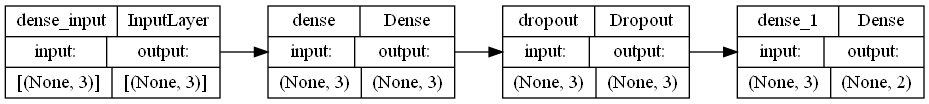

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

As shown above, the neural network possesses 3 input nodes, 1 hidden layers each with three nodes and an output of two which will indicate whether the fruit is a pineapple or a banana. The Flatten layer converts the input into a 1D array while the Dropout Layer in tensorflow is used only during the training step and is meant to prevent overfitting while training the model. A summary of the model can be seen below:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


Now that the neural network is able to appropriately classify, one can create a test that determines whether the neural network performs well.

In [16]:
def test(x_test, y_test, model=model):
    evaluation = model.evaluate(x_test, y_test, batch_size=128)
    return evaluation

test(X_test,y_test)

71/71 [==============================] - 1s 8ms/step - loss: 0.0294 - Accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - tp: 9000.0000 - tn: 9000.0000 - auc: 1.0000


[0.029387911781668663, 1.0, 1.0, 1.0, 9000.0, 9000.0, 1.0]

The test above was done using a series of random records that were chosen based on the function above. As shown by the resulting values, the model is very accurate at predicting whether the fruit in question is a pineapple or a banana is a matter of whether the fruit is rough or smooth (pineapples will always have a rough texture, whereas bananas will always have a smooth texture).

## Proposition

Automating this process is not very difficult, to supplement the introduction of new fruits into the model, one may want to create a form of data pipeline where the initial data or expected properties are introduced into the model which can be retrained everytime there is a new fruit introduced. Now a better idea may involve obtaining the exact weight, provide more variety selection of shape, and provide a new feature such as color. With this, one should be able to develop an unsupervised model, such as  a Kmeans model, that can categorize the fruit. Once the fruit is categorized, an employee may supply the appropriate name of the fruit based on the properties. 